1. Try to generate 100 terms by LO and RI and left only terms with equal count of steps.

In [1]:
import random
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions
from deap import tools, base, creator
import seaborn as sns

sys.path.append("../")
from calculus.term import *
from calculus.strategy import *
from calculus.generation import *
from calculus.generation_threading import *

from calculus_utils.drawing import *
from calculus_utils.algorithms import *
from calculus_utils.outliers_cleaning import clear_arr

from vd_env.lambda_env import LambdaEnv
from vd_env.run_greedy_policy import run_greedy_policy
from vd_env.run_e_greedy_policy import run_e_greedy_policy

## Try to generate 100 terms by LO and RI and left only terms with equal count of steps.

In [2]:
RANDOM_AVERAGE_COUNT = 20

terms, stepsLO = gen_filtered_lambda_terms_v2(count_terms=100, filtering_strategy=LeftmostOutermostStrategy())
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]
stepsRand_RO = [sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT)) / RANDOM_AVERAGE_COUNT
                for term in tqdm(terms)]

100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


In [7]:
equal_steps = []
greater_steps = []
smaller_steps = []

for i, s_LO in enumerate(stepsLO):
    if s_LO == stepsRI[i]:
        equal_steps.append(i)
    elif s_LO > stepsRI[i]:
        greater_steps.append(i)
    elif s_LO < stepsRI[i] != np.inf:
        smaller_steps.append(i)

In [8]:
print(equal_steps)
print(greater_steps)
print(smaller_steps)

[0, 5, 11, 25, 32, 39, 50, 53, 55, 56, 63, 72, 77, 80, 87, 91, 96]
[2, 13, 14, 24, 33, 37, 40, 41, 59, 62, 64, 70, 84, 86, 88, 92]
[1, 3, 4, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 34, 35, 36, 38, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 54, 57, 58, 60, 61, 65, 66, 68, 69, 71, 73, 74, 75, 76, 78, 79, 81, 82, 83, 85, 89, 90, 93, 94, 95, 97, 98, 99]


In [9]:
print(len(equal_steps))
print(len(greater_steps))
print(len(smaller_steps))

17
16
66


In [11]:
count_smaller = int((len(equal_steps) + len(greater_steps)) / 2)
smaller_steps = smaller_steps[:count_smaller]

16


## Try to generate 100 FILTERED terms by LO and RI.

In [2]:
def balance_filtered_term_gen(expected_count=100):
    terms_balanced = []
    while len(terms_balanced) < expected_count:
        terms, stepsLO = gen_filtered_lambda_terms_v2(count_terms=100, filtering_strategy=LeftmostOutermostStrategy())
        stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]

        equal_steps = []
        greater_steps = []
        smaller_steps = []

        for i, s_LO in enumerate(stepsLO):
            if s_LO == stepsRI[i]:
                equal_steps.append(i)
            elif s_LO > stepsRI[i]:
                greater_steps.append(i)
            elif s_LO < stepsRI[i] != np.inf:
                smaller_steps.append(i)

        count_smaller = int((len(equal_steps) + len(greater_steps)) / 2)
        smaller_steps = smaller_steps[:count_smaller]
        for inx in equal_steps + greater_steps + smaller_steps:
            terms_balanced.append(terms[inx])
        print(f"Generated & balanced {len(terms_balanced)} terms")

    return terms_balanced



In [3]:
terms_gen = balance_filtered_term_gen(expected_count=100)

100%|██████████| 100/100 [00:00<00:00, 666.52it/s]


Generated & balanced 58 terms


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Generated & balanced 107 terms


In [4]:
RANDOM_AVERAGE_COUNT = 20

stepsLO = [term.normalize(LeftmostOutermostStrategy())[1] for term in tqdm(terms_gen)]
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms_gen)]
stepsRand = [sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT)) / RANDOM_AVERAGE_COUNT
                for term in tqdm(terms_gen)]

100%|██████████| 107/107 [00:45<00:00,  2.35it/s]


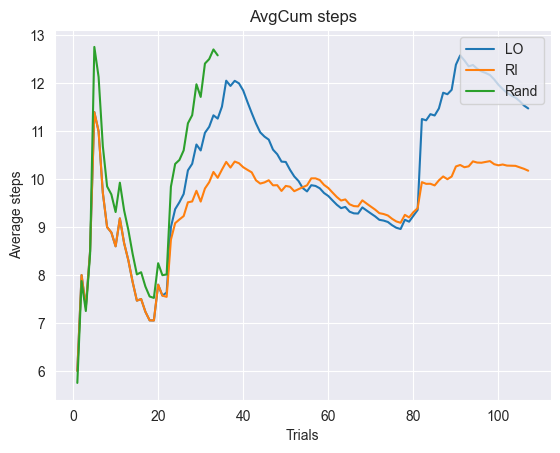

In [6]:
comp_data = {
    "LO": (stepsLO, "-"),
    "RI": (stepsRI, "-"),
    "Rand": (stepsRand, "-"),
}
draw_cumulative_avg_comparison(comp_data, title="AvgCum steps")

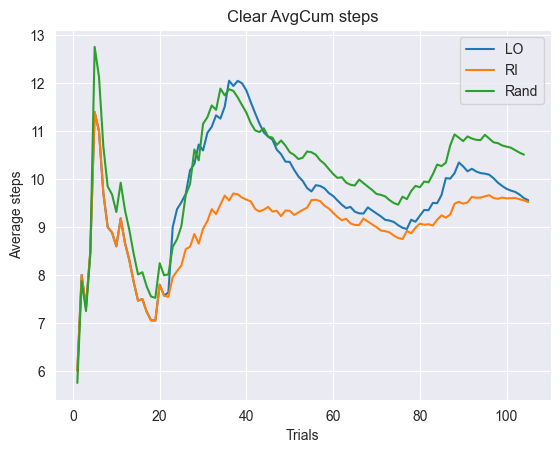

In [7]:
comp_data = {
    "LO": (clear_arr(stepsLO), "-"),
    "RI": (clear_arr(stepsRI), "-"),
    "Rand": (clear_arr(stepsRand), "-"),
}
draw_cumulative_avg_comparison(comp_data, title="Clear AvgCum steps")

In [8]:
steps_mixed_all = []
expected_values = []
values = list(range(0, 101, 5))
iters = len(values) - 1

for inx, p_lo in enumerate(values):
    p = (p_lo / 100, 1 - p_lo / 100)
    steps = [sum([term.normalize(MixedStrategy([LeftmostOutermostStrategy(), RightmostInnermostStrategy()], p))[1]
                  for i in range(RANDOM_AVERAGE_COUNT)]) / RANDOM_AVERAGE_COUNT
             for term in tqdm(terms_gen, desc=f"it {inx} / {iters}")]
    steps_mixed_all.append(steps)

it 20 / 20: 100%|██████████| 107/107 [00:08<00:00, 12.87it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 32.25it/s]


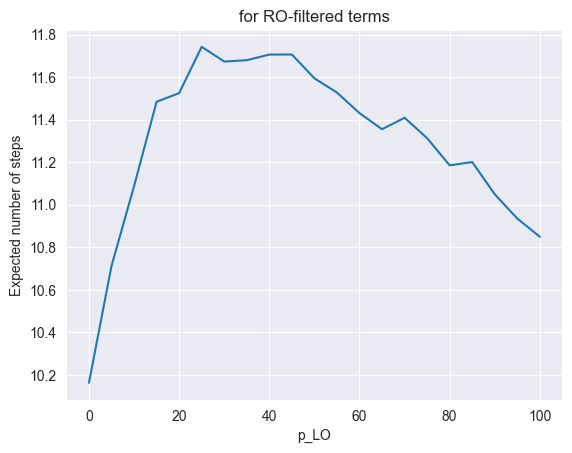

In [9]:
for steps in steps_mixed_all:
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    expected_values.append(result)

plt.plot(values, expected_values)
plt.xlabel("p_LO")
plt.ylabel("Expected number of steps")
plt.title("for RO-filtered terms")
plt.show()

In [10]:
inx_best = expected_values.index(min(expected_values))
inx_best

0

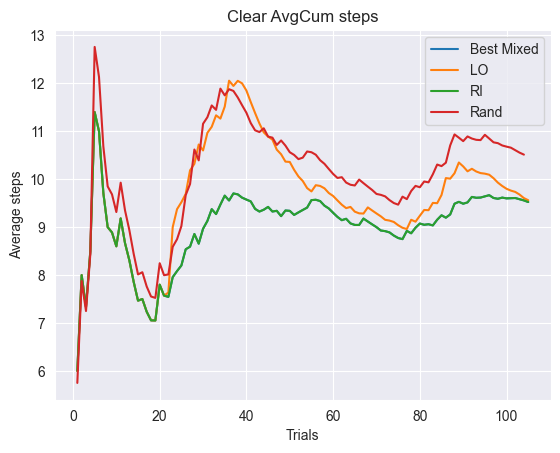

In [13]:
comp_data = {
    "Best Mixed": (clear_arr(steps_mixed_all[inx_best]), "-"),
    "LO": (clear_arr(stepsLO), "-"),
    "RI": (clear_arr(stepsRI), "-"),
    "Rand": (clear_arr(stepsRand), "-"),
}
draw_cumulative_avg_comparison(comp_data, title="Clear AvgCum steps")